In [75]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# Prepare data
policy = pd.read_excel('/Users/Jenny/Desktop/COVID19/cleaned/COVID-19 US state policy database 6_10_2020.xlsx', skiprows = range(1, 5))
mobility = pd.read_csv('/Users/Jenny/Desktop/COVID19/cleaned/covid19_us_summary.csv')
# Fix NV's FM_ALL
policy.loc[policy['POSTCODE']=='NV', 'FM_ALL'] = 0
policy.head(3)

,STATE,POSTCODE,STEMERG,CLSCHOOL,CLDAYCR,CLNURSHM,STAYHOME,END_STHM,CLBSNS,END_BSNS,...,PDSKLV,MEDEXP,POPDEN18,POP18,SQML,HMLS19,UNEMP18,POV18,RISKCOV,DEATH18
0,Alabama,AL,2020-03-13,2020-03-19 00:00:00,2020-03-20 00:00:00,2020-03-19 00:00:00,2020-04-04 00:00:00,2020-04-30 00:00:00,2020-03-28 00:00:00,2020-04-30 00:00:00,...,0,0,93.24,4887871,52420.0,3261,5.6,16.8,43.1,54352
1,Alaska,AK,2020-03-11,2020-03-16 00:00:00,0,0,2020-03-28 00:00:00,2020-04-24 00:00:00,2020-03-28 00:00:00,2020-04-24 00:00:00,...,0,1,1.11,737438,665384.0,1907,6.8,10.9,32.8,4453
2,Arizona,AZ,2020-03-11,2020-03-16 00:00:00,0,0,2020-03-31 00:00:00,2020-05-16 00:00:00,2020-03-30 00:00:00,2020-05-08 00:00:00,...,1,1,62.91,7171646,113990.0,10007,5.4,14.0,39.1,59282


In [40]:
mobility['a_date'] = pd.to_datetime(mobility['a_date'])
mobility.head(3)

,a_state,a_date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,b_state,b_date,confirmed_cases_state,deaths_state
0,AL,2020-02-15,5,2,39.0,7,2,-1,AL,2020-02-15,0,0
1,AL,2020-02-16,0,-2,-7.0,3,-1,1,AL,2020-02-16,0,0
2,AL,2020-02-17,3,0,17.0,7,-17,4,AL,2020-02-17,0,0


# Data Prep
#close: 'CLNURSHM', 'EVICINTN', 'EVICENF'
a = ['STEMERG', 'CLSCHOOL', 'CLDAYCR', 'STAYHOME', 'CLBSNS', 'FM_ALL', 'FM_EMP', 'CLREST', 'CLGYM', 'CLMOVIE']

#reopen: 'END_MOV'
b = ['END_STHM', 'END_BSNS', 'ENDREST', 'ENDGYM']


one time
['STEMERG', 'CLSCHOOL', 'CLDAYCR', 'FM_ALL', 'FM_EMP']

start-end pair
['STAYHOME', 'CLBSNS','CLREST', 'CLGYM', 'CLMOVIE', 'END_STHM', 'END_BSNS', 'ENDREST', 'ENDGYM', 'END_MOV']

In [48]:
onetime = ['STEMERG', 'CLSCHOOL', 'CLDAYCR', 'FM_ALL', 'FM_EMP']
pair = [('STAYHOME','END_STHM'), ('CLBSNS','END_BSNS'), ('CLREST','ENDREST'),
        ('CLGYM','ENDGYM'), ('CLMOVIE','END_MOV')]

In [63]:
def onetimePolicy_dummy(mobility_df, policy_df, policy_list):
    """
    policy_list: a list of policy names
    mobility_df: mobility dataset
    policy_df: policy dataset
    """

    df = policy_df[['POSTCODE']+policy_list]
    df = df.replace(0, datetime.datetime(2020,12,31))
    output = mobility_df.merge(df, how='left', left_on='a_state', right_on='POSTCODE')
    for policy in policy_list:
        output[policy] = (output[policy] <= output['a_date'])*1
        
    return output

data = onetimePolicy_dummy(mobility, policy, onetime)

In [64]:
def startendPolicy_dummy(mobility_df, policy_df, policy_list):
    """
    policy_list: a list of policy names, should be in thie format [(start, end), (start, end)]
    mobility_df: mobility dataset
    policy_df: policy dataset
    """
    
    from itertools import chain
    policy_list_flattened = list(chain.from_iterable(policy_list))
    df = policy_df[['POSTCODE'] + policy_list_flattened]
    df = df.replace(0, datetime.datetime(2020,12,31))
    
    output = mobility_df.merge(df, how='left', left_on='a_state', right_on='POSTCODE')
    for start, end in policy_list:
        output[start] = (output[start] <= output['a_date'])*1
        output[start] = np.where(output[end] > output['a_date'], output[start], 0)
        output[end] = (output[end] <= output['a_date'])*1
    
    return output
    
data = startendPolicy_dummy(data, policy, pair)

,a_state,a_date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,b_state,b_date,...,STAYHOME,END_STHM,CLBSNS,END_BSNS,CLREST,ENDREST,CLGYM,ENDGYM,CLMOVIE,END_MOV
0,AL,2020-02-15,5,2,39.0,7,2,-1,AL,2020-02-15,...,0,0,0,0,0,0,0,0,0,0
1,AL,2020-02-16,0,-2,-7.0,3,-1,1,AL,2020-02-16,...,0,0,0,0,0,0,0,0,0,0
2,AL,2020-02-17,3,0,17.0,7,-17,4,AL,2020-02-17,...,0,0,0,0,0,0,0,0,0,0
3,AL,2020-02-18,-4,-3,-11.0,-1,1,2,AL,2020-02-18,...,0,0,0,0,0,0,0,0,0,0
4,AL,2020-02-19,4,1,6.0,4,1,0,AL,2020-02-19,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5809,WY,2020-06-03,5,17,132.0,18,-24,6,WY,2020-06-03,...,0,0,0,1,0,1,0,1,0,1
5810,WY,2020-06-04,5,22,146.0,22,-24,5,WY,2020-06-04,...,0,0,0,1,0,1,0,1,0,1
5811,WY,2020-06-05,-1,18,176.0,28,-24,5,WY,2020-06-05,...,0,0,0,1,0,1,0,1,0,1
5812,WY,2020-06-06,-7,12,135.0,27,-10,3,WY,2020-06-06,...,0,0,0,1,0,1,0,1,0,1


# EDA
Distribution of Y

In [80]:
Y = ['retail_and_recreation', 'grocery_and_pharmacy', 'transit_stations', 'workplaces', 'residential']
data[Y].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5814 entries, 0 to 5813
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   retail_and_recreation  5814 non-null   int64
 1   grocery_and_pharmacy   5814 non-null   int64
 2   transit_stations       5814 non-null   int64
 3   workplaces             5814 non-null   int64
 4   residential            5814 non-null   int64
dtypes: int64(5)
memory usage: 272.5 KB


retail_and_recreation


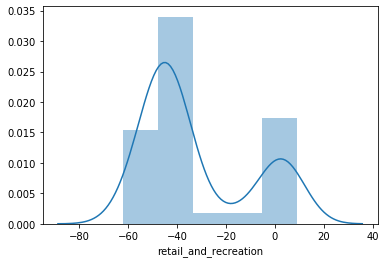

grocery_and_pharmacy


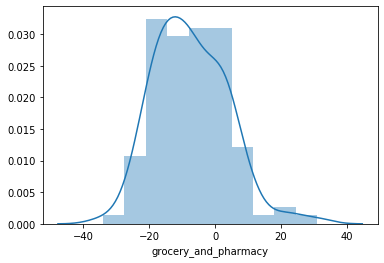

transit_stations


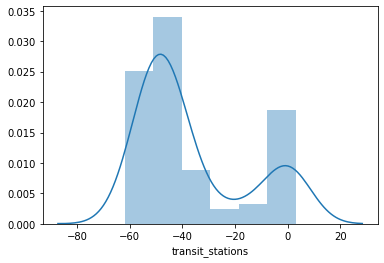

workplaces


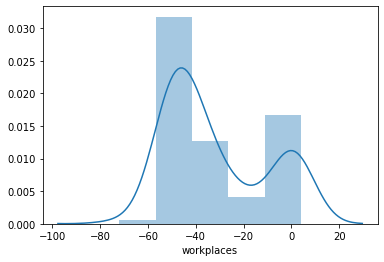

residential


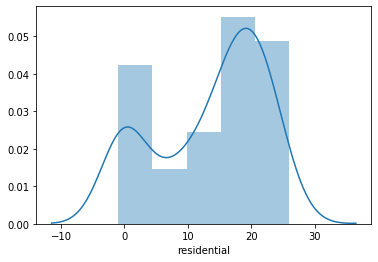

retail_and_recreation


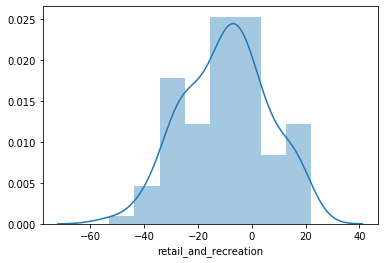

grocery_and_pharmacy


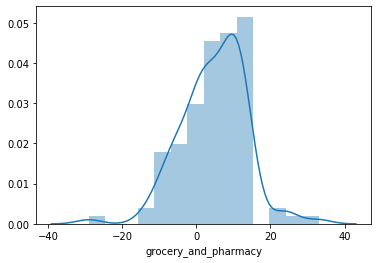

transit_stations


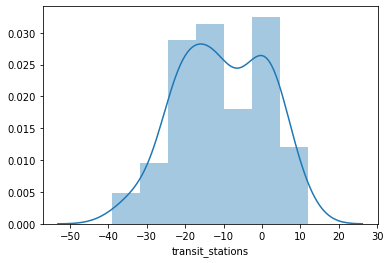

workplaces


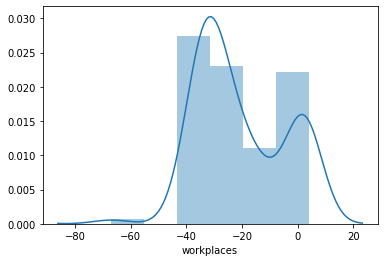

residential


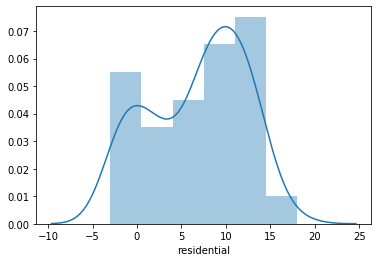

In [83]:
for state in ['CA', 'AR']:
    for y in Y:
        print(y)
        sns.distplot(data.loc[data['a_state']==state, y])
        plt.show()

# Baseline model
Linear regression model

In [139]:
model_df['retail_and_recreation'].diff()

0      NaN
1     -6.0
2     -1.0
3      0.0
4     -1.0
      ... 
108    3.0
109    1.0
110   -2.0
111   -1.0
112    2.0
Name: retail_and_recreation, Length: 113, dtype: float64

In [100]:
from itertools import chain
pair_flattened = list(chain.from_iterable(pair))
cols = ['retail_and_recreation'] + onetime + pair_flattened
model_df = data.loc[data['a_state']=='IL', cols]
model_df['y_diff'] = model_df['retail_and_recreation'].diff()
model_df = model_df.dropna()
model_df = model_df.reset_index(drop=True)     

In [105]:
# IL
import statsmodels.api as sm
X = sm.add_constant(model_df[onetime + pair_flattened])
mod = sm.OLS(model_df['retail_and_recreation'], X)

In [106]:
result = mod.fit()
print(result.summary())

                              OLS Regression Results                             
Dep. Variable:     retail_and_recreation   R-squared:                       0.942
Model:                               OLS   Adj. R-squared:                  0.938
Method:                    Least Squares   F-statistic:                     243.2
Date:                   Wed, 17 Jun 2020   Prob (F-statistic):           7.41e-62
Time:                           22:48:17   Log-Likelihood:                -341.11
No. Observations:                    113   AIC:                             698.2
Df Residuals:                        105   BIC:                             720.0
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7273 

Model suffers from high multicollinearity. 

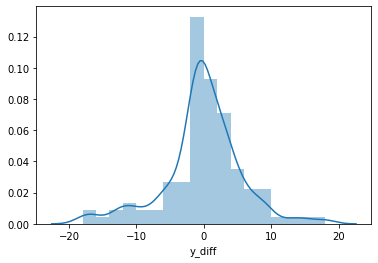

In [138]:
sns.distplot(model_df['y_diff'])

# Bayesian Approach

In [107]:
import pystan
import arviz as az

In [ ]:
N = model_df.shape[0]
Nx = model_df.shape[1]-2
y = model_df['y_diff']
x = model_df.drop(['retail_and_recreation', 'y_diff'], axis=1)

modelscript = """
data {
    int<lower=0> N;
    int<lower=0> Nx;
    real y[N];
    matrix[N, Nx] x;
}
parameters {
    real beta0;
    vector[Nx] beta;
}
model {
    beta0 ~ cauchy(0,10);
    
    for (i in 1:Nx)
        beta[i] ~ normal(0,5);
    
    y ~ normal(beta0 + x*beta, 5);
}

"""

datalist = {'N': N,
           'Nx': Nx,
           'y': y,
           'x': x}

model = pystan.StanModel(model_code = modelscript)
model_fit = model.sampling(data=datalist, seed=9, iter=1000, chains=2)

In [119]:
az.summary(model_fit)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0,0.297,1.073,-1.585,2.396,0.027,0.029,1561.0,708.0,1541.0,825.0,1.00
beta[0],-3.241,1.925,-6.934,0.320,0.054,0.038,1288.0,1288.0,1293.0,691.0,1.00
beta[1],-2.331,3.156,-7.991,3.630,0.119,0.084,709.0,709.0,710.0,698.0,1.00
beta[2],9.903,2.681,4.649,14.722,0.059,0.046,2056.0,1673.0,2079.0,747.0,1.02
beta[3],-0.048,3.663,-7.276,6.137,0.131,0.120,779.0,463.0,796.0,729.0,1.00
beta[4],-0.177,3.627,-7.404,6.159,0.132,0.124,754.0,426.0,757.0,594.0,1.01
beta[5],-0.641,4.293,-8.240,7.701,0.127,0.141,1137.0,466.0,1145.0,660.0,1.00
beta[6],-0.503,4.507,-9.224,7.755,0.114,0.156,1565.0,416.0,1545.0,511.0,1.00
beta[7],-0.844,4.347,-9.224,6.700,0.109,0.141,1593.0,473.0,1618.0,677.0,1.00
beta[8],-0.706,4.626,-9.396,7.818,0.128,0.162,1301.0,410.0,1296.0,647.0,1.01


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2a0316a0>,
      dtype=object)

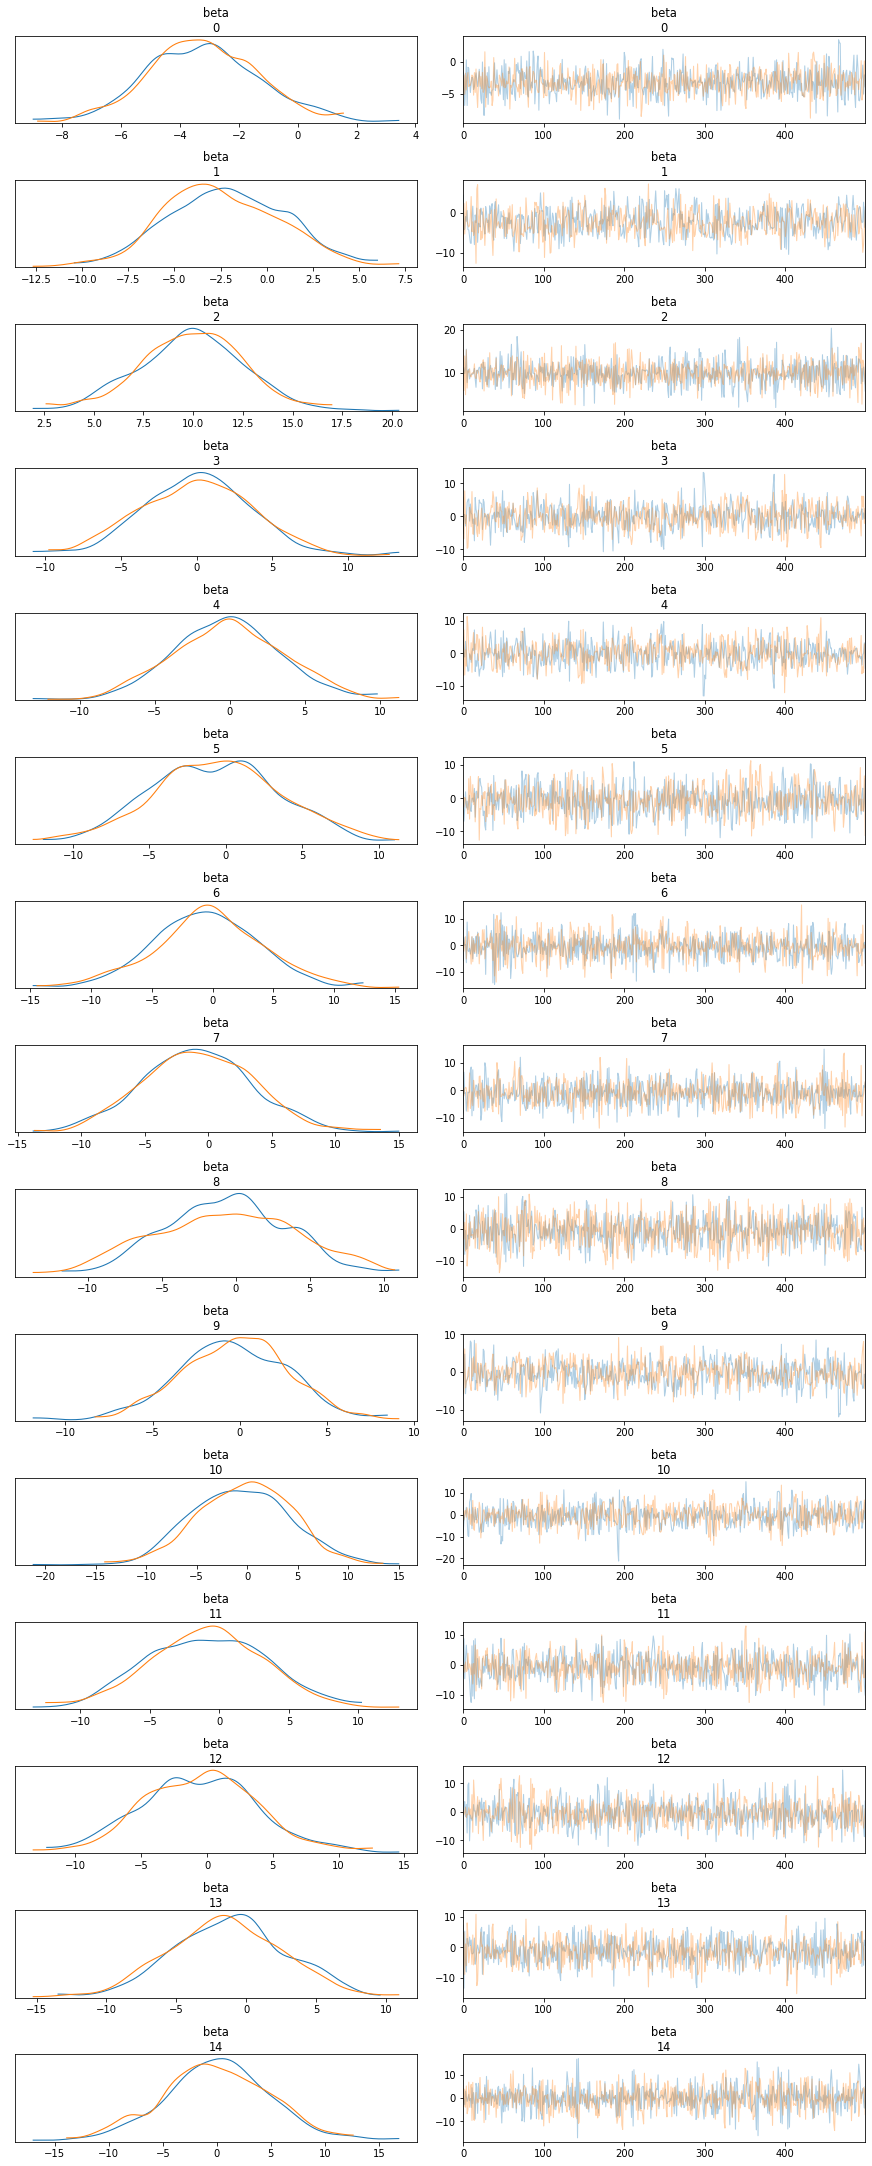

In [120]:
az.plot_trace(model_fit, var_names='beta')

In [123]:
# cumsum
model_df[onetime + pair_flattened] = model_df[onetime + pair_flattened].cumsum()

In [129]:
N = model_df.shape[0]
Nx = model_df.shape[1]-2
y = model_df['y_diff']
x = model_df.drop(['retail_and_recreation', 'y_diff'], axis=1)

modelscript = """
data {
    int<lower=0> N;
    int<lower=0> Nx;
    real y[N];
    matrix[N, Nx] x;
}
parameters {
    real beta0;
    vector[Nx] beta;
}
model {
    beta0 ~ cauchy(0,10);
    
    for (i in 1:Nx)
        beta[i] ~ normal(0,5);
    
    y ~ normal(beta0 + x*beta, 5);
}

"""

datalist = {'N': N,
           'Nx': Nx,
           'y': y,
           'x': x}

model = pystan.StanModel(model_code = modelscript)
model_fit = model.sampling(data=datalist, seed=9, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_af947a31060e16874490c93537918dec NOW.


In [133]:
summary = az.summary(model_fit)
summary['policy'] = ['intercept'] + onetime + pair_flattened

In [134]:
summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,policy
beta0,0.223,1.004,-1.783,2.087,0.107,0.076,88.0,88.0,89.0,170.0,1.00,intercept
beta[0],-0.793,0.357,-1.468,-0.140,0.037,0.026,94.0,94.0,94.0,168.0,1.01,STEMERG
beta[1],1.777,3.095,-3.694,7.587,0.427,0.303,53.0,53.0,53.0,127.0,1.01,CLSCHOOL
beta[2],-1.846,1.668,-4.962,1.127,0.156,0.110,115.0,115.0,118.0,261.0,1.02,CLDAYCR
beta[3],-0.486,3.607,-7.193,5.952,0.428,0.304,71.0,71.0,72.0,178.0,1.02,FM_ALL
beta[4],0.438,3.615,-6.129,7.049,0.429,0.305,71.0,71.0,72.0,176.0,1.02,FM_EMP
beta[5],0.160,4.213,-7.626,7.774,0.459,0.326,84.0,84.0,85.0,197.0,1.04,STAYHOME
beta[6],-0.120,5.162,-9.362,9.532,0.903,0.645,33.0,33.0,33.0,44.0,1.06,END_STHM
beta[7],0.225,4.667,-9.069,8.700,0.522,0.371,80.0,80.0,81.0,145.0,1.01,CLBSNS
beta[8],-0.253,4.541,-10.041,8.170,0.490,0.348,86.0,86.0,88.0,140.0,1.03,END_BSNS


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2ac552b0>,
      dtype=object)

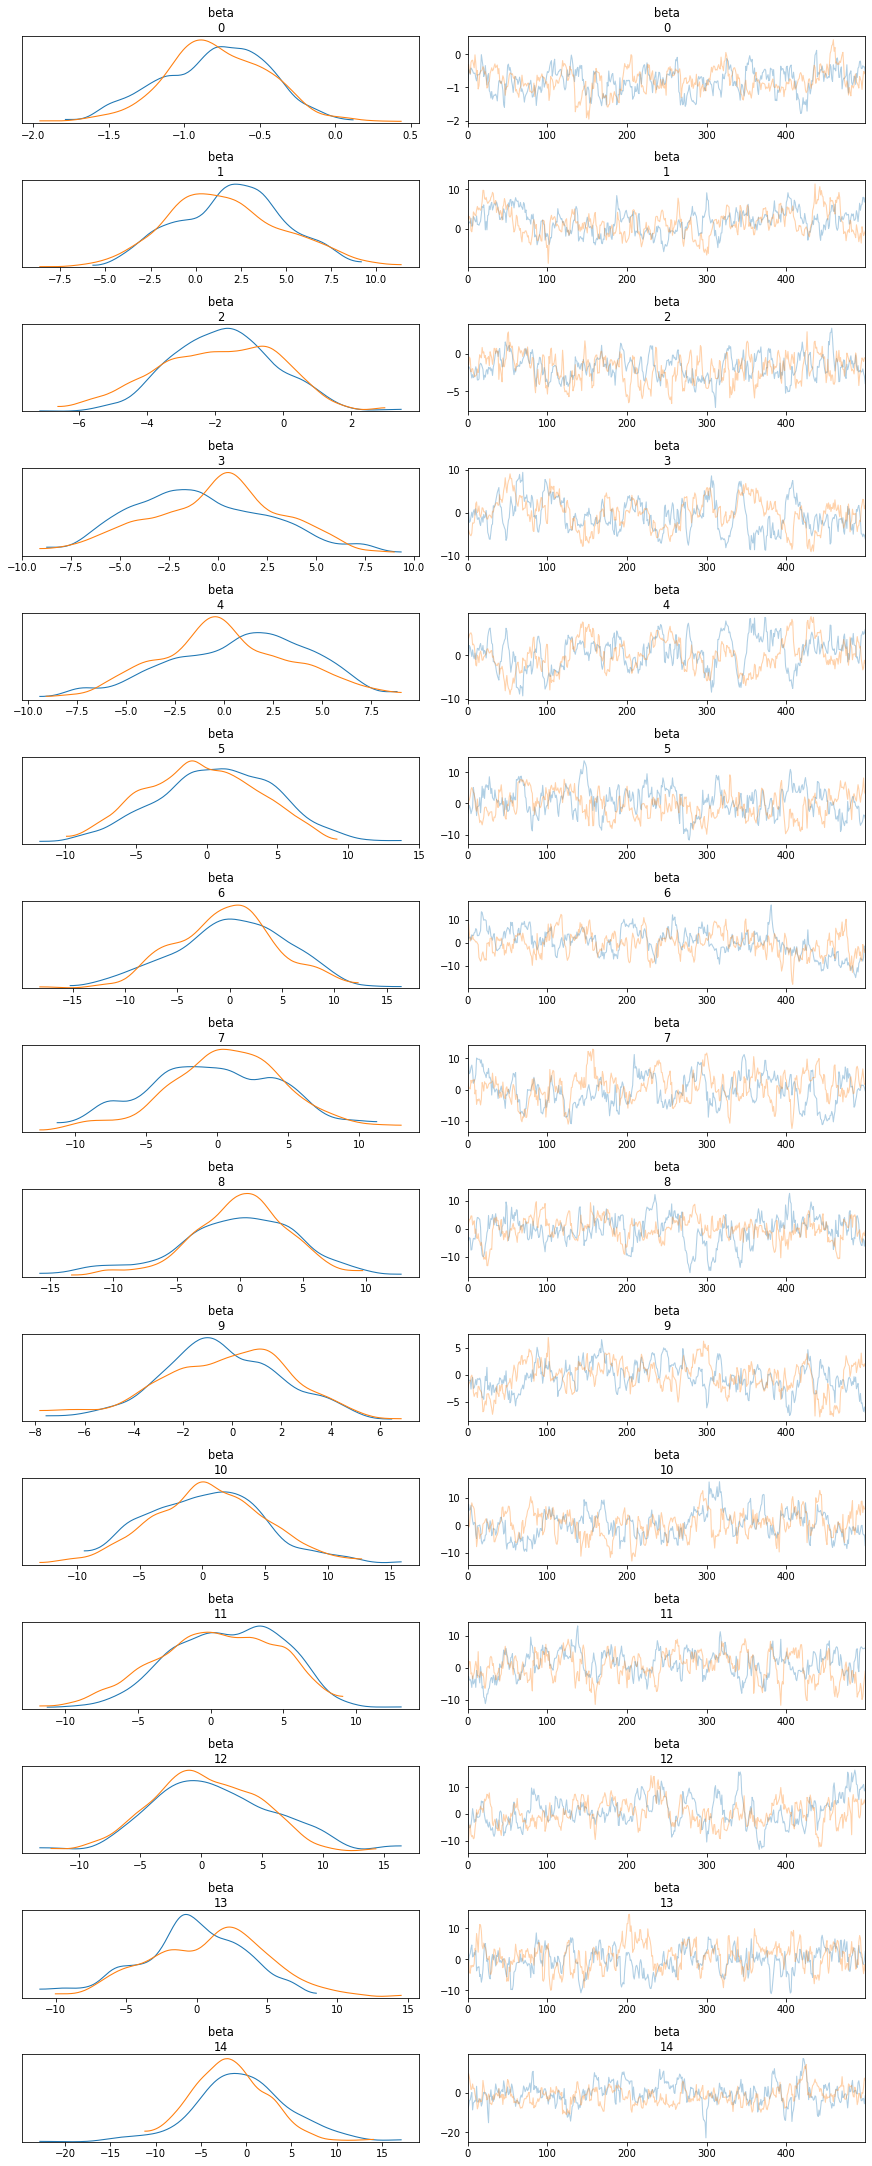

In [132]:
az.plot_trace(model_fit, var_names='beta')

#### weights
